# Learning GAN and WGAN for a synthetic 2-dimensional dataset

<br/><br/>
<a target="_blank" href="https://colab.research.google.com/github/generativemodelingmva/generativemodelingmva.github.io/blob/main/tp2425/tp3_generative_networks.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<br/><br/>

This practical session contains
- "QUESTION" fields in the text
- blocks of code that you should complete at every region marked with ### ... ###

We advise you to open the notebooks on Google Colab.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

cuda


### Target Measure

In the following cell, we define the discrete target measure $\nu$ that will serve as dataset for this practical session.

The variable `xgrid` contains a grid of points that will be useful below to display the discriminators along training.

In [9]:
type(torch.ones(n,n))

torch.Tensor

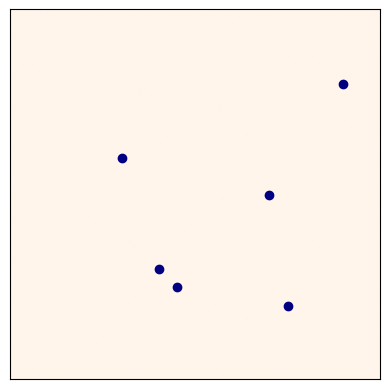

In [2]:
d = 2   # dimension of the data points
n = 6   # number of data points

y = torch.zeros((n,d), device=device)
y[0, 0] = 0.9
y[0, 1] = 0.2

y[1, 0] = 0.75
y[1, 1] = 0.8

y[2, 0] = 0.3
y[2, 1] = 0.4

y[3, 0] = 0.4
y[3, 1] = 0.7

y[4, 0] = 0.45
y[4, 1] = 0.75

y[5, 0] = 0.7
y[5, 1] = 0.5

nu = torch.ones(n, device=device)/n  # equal masses (nu is the empirical measure of the data)

# generate grid for plotting purpose
nr,nc = 256,256
extent = ((-0.5/nc, 1-0.5/nc, 1-0.5/nr, -0.5/nr))
xs = torch.linspace(0, 1, steps=nr)
ys = torch.linspace(0, 1, steps=nc)
xm, ym = torch.meshgrid(xs, ys, indexing='ij')
xm = xm.T
ym = ym.T
xgrid = torch.cat((xm.reshape(nr*nc,1),ym.reshape(nr*nc,1)),1).to(device)

# Plot data points
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Define Generator architecture

QUESTION: Examine the layers and parameters of the following generative network.

In [10]:
class Generator(torch.nn.Module):

    def __init__(self, n_in, n_out, n_hid=10, nlayers=3, device=torch.device("cpu")):
        super(Generator, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()

        for n in range(nlayers):
            n_in_t = n_in if n==0 else n_hid
            self.hidden.append(nn.Sequential(
            nn.Linear(n_in_t, n_hid),
            nn.ELU(1)
        ).to(device))

        self.out = nn.Sequential(
            nn.Linear(n_hid, n_out),
            nn.Sigmoid()
        ).to(device)

        self.apply(self._init_weights)


    def forward(self, x):
        for n in range(self.nlayers):
            x = self.hidden[n](x)
        x = self.out(x)
        return x


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()


QUESTION: Plot one initial configuration of the generator (draw a batch of generated points)

torch.Size([100, 2])


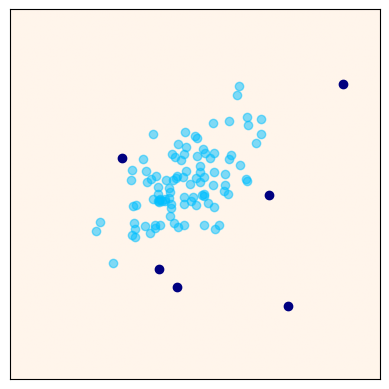

In [12]:
torch.manual_seed(0)  # initialize random seed for reproducibility

n_in = 10    # dimension of the input noise
b = 100      # batch size

# Initialize generator
G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)

# Draw a batch x of generated points
#    Input noise z : standard normal with shape (b, n_in)

### ... ##

# Moi: on génère x à partir du bruit

z = torch.randn(b, n_in, device= device)

x = G(z)

print(x.shape)

xd = x.detach()
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy') # je ne comprends pas ce y .
plt.show()

<br/><br/><br/><br/>

# Exercise 1: WGAN Learning

## Discriminator Architecture

QUESTION: Examine the layers and parameters of the following discriminative network.

In [13]:
nn.Linear(1,1).shape

AttributeError: 'Linear' object has no attribute 'shape'

In [14]:
class DWGAN(nn.Module):
  def __init__(self, n_in, n_hid=10):
    super(DWGAN, self).__init__()

    self.n_hid = n_hid
    self.n_in = n_in

    self.fc1 = nn.Linear(n_in, n_hid)
    self.fc2 = nn.Linear(n_hid, n_hid)
    self.fc3 = nn.Linear(n_hid, 1)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    y = self.fc3(y)
    return y

## Weight clipping

QUESTION: For a fixed generator, train the discriminator with WGAN loss and weight clipping.

Try changing the clip_value. What do you observe?

In [ ]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(1)  # initialize random seed for reproducibility

# fix one generator
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD = 1000

clip_value = 0.1  # Try changing this value to observe different effects

# Instantiate the WGAN critic/discriminator
D = DWGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # display current configuration each iter_display iteration

# List to keep track of discriminator loss
Dlosses = []

# Assume dataloader is defined and yields batches of real data of shape (batch_size, d)
data_iterator = iter(dataloader)

for iter in range(niterD):

    ### UPDATE OF D ###
    # Get a batch of real data. If the iterator is exhausted, reinitialize it.
    try:
        real_data = next(data_iterator)
    except StopIteration:
        data_iterator = iter(dataloader)
        real_data = next(data_iterator)
    real_data = real_data.to(device)
    batch_size = real_data.size(0)

    # Compute critic output for real data
    D_real = D(real_data)

    # Generate fake data: sample noise, pass through generator
    noise = torch.randn(batch_size, n_in, device=device)
    fake_data = G(noise).detach()  # detach to avoid updating G during D's training
    D_fake = D(fake_data)

    # Compute WGAN critic loss: maximize E[D(real)] - E[D(fake)]
    # For minimization we take the negative of this difference.
    Dloss = - (torch.mean(D_real) - torch.mean(D_fake))

    # Zero gradients, backpropagate, and update discriminator's parameters
    optimD.zero_grad()
    Dloss.backward()
    optimD.step()

    # Weight clipping step: enforce Lipschitz constraint by clamping parameters
    for p in D.parameters():
        p.data.clamp_(-clip_value, clip_value)

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)  # storing the (positive) Wasserstein estimate

    if iter % iter_display == 0:
        print('[%d/%d], Loss: %f' % (iter, niterD, Dlosst))
        # Visualization (assuming xgrid, nr, nc, z, extent, y are defined)
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr, nc)
        # Generate some fake samples for visualization purposes
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter ' + str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid, cmap='Oranges', extent=extent)  # visualize critic's output
        plt.scatter(xd[:, 0].cpu(), xd[:, 1].cpu(), c='deepskyblue', alpha=0.5)
        plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c='navy')
        plt.title(strtitle)
        plt.show()

plt.plot(Dlosses)
plt.xlabel('Iteration')
plt.ylabel('Wasserstein Estimate')
plt.title('Discriminator Loss over Time')
plt.show()


In [15]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# fix one generator
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000

clip_value = .1

D = DWGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###
    ### ... (optim of D) ... ###
    ### ... (weight clipping step) ... ###
    optimD.zero_grad()
    Dloss = ### ... ###
    Dloss.backward()
    optimD.step()






    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

plt.plot(Dlosses)

SyntaxError: invalid syntax (<ipython-input-15-a61cdd9375c0>, line 28)

QUESTION: Now, train both the generator and discriminator with the WGAN loss and weight clipping.

[1/100] 	Loss_D: -0.0151	Loss_G: 0.0633
[2/100] 	Loss_D: -0.0230	Loss_G: 0.1330
[3/100] 	Loss_D: -0.0196	Loss_G: 0.1067
[4/100] 	Loss_D: -0.0098	Loss_G: 0.0909
[5/100] 	Loss_D: -0.0135	Loss_G: 0.1010
[6/100] 	Loss_D: -0.0075	Loss_G: 0.0825
[7/100] 	Loss_D: -0.0347	Loss_G: 0.1202
[8/100] 	Loss_D: -0.0240	Loss_G: 0.1042
[9/100] 	Loss_D: -0.0191	Loss_G: 0.0956
[10/100] 	Loss_D: -0.0094	Loss_G: 0.0911


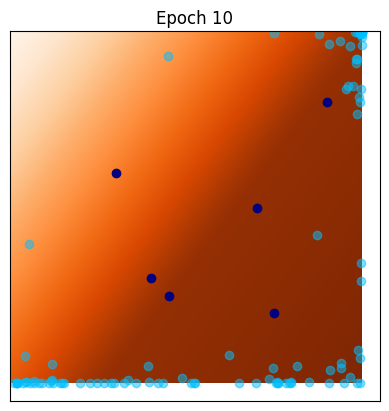

[11/100] 	Loss_D: -0.0067	Loss_G: 0.1013
[12/100] 	Loss_D: -0.0246	Loss_G: 0.1118
[13/100] 	Loss_D: -0.0287	Loss_G: 0.1322
[14/100] 	Loss_D: -0.0259	Loss_G: 0.1104
[15/100] 	Loss_D: -0.0165	Loss_G: 0.1019
[16/100] 	Loss_D: -0.0096	Loss_G: 0.0885
[17/100] 	Loss_D: -0.0284	Loss_G: 0.1165
[18/100] 	Loss_D: -0.0256	Loss_G: 0.0965
[19/100] 	Loss_D: -0.0182	Loss_G: 0.1241
[20/100] 	Loss_D: -0.0160	Loss_G: 0.1094


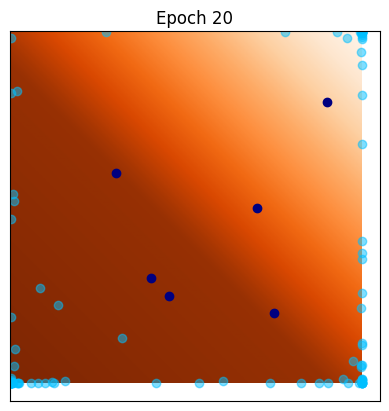

[21/100] 	Loss_D: -0.0046	Loss_G: 0.0911
[22/100] 	Loss_D: -0.0141	Loss_G: 0.1058
[23/100] 	Loss_D: -0.0172	Loss_G: 0.1068
[24/100] 	Loss_D: -0.0077	Loss_G: 0.0942
[25/100] 	Loss_D: -0.0363	Loss_G: 0.1294
[26/100] 	Loss_D: -0.0347	Loss_G: 0.1218
[27/100] 	Loss_D: -0.0203	Loss_G: 0.1277
[28/100] 	Loss_D: -0.0178	Loss_G: 0.1187
[29/100] 	Loss_D: -0.0170	Loss_G: 0.1080
[30/100] 	Loss_D: -0.0087	Loss_G: 0.1037


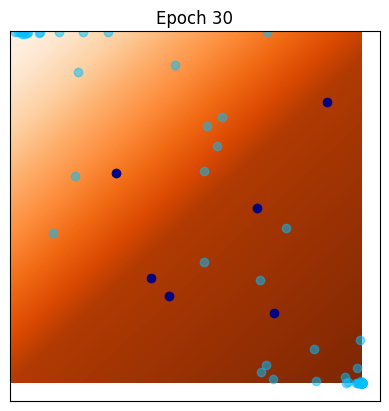

[31/100] 	Loss_D: 0.0002	Loss_G: 0.0964
[32/100] 	Loss_D: -0.0458	Loss_G: 0.1499
[33/100] 	Loss_D: -0.0398	Loss_G: 0.1325
[34/100] 	Loss_D: -0.0366	Loss_G: 0.1390
[35/100] 	Loss_D: -0.0189	Loss_G: 0.1267
[36/100] 	Loss_D: -0.0149	Loss_G: 0.1248
[37/100] 	Loss_D: -0.0122	Loss_G: 0.1131
[38/100] 	Loss_D: -0.0060	Loss_G: 0.0993
[39/100] 	Loss_D: -0.0261	Loss_G: 0.1182
[40/100] 	Loss_D: -0.0215	Loss_G: 0.1283


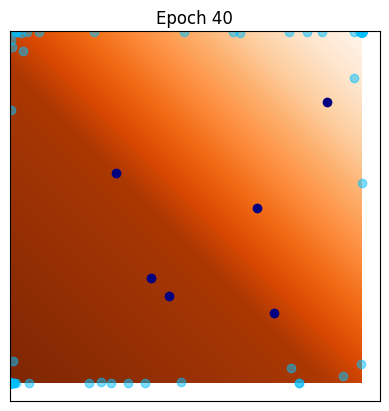

[41/100] 	Loss_D: -0.0174	Loss_G: 0.1306
[42/100] 	Loss_D: -0.0160	Loss_G: 0.1293
[43/100] 	Loss_D: -0.0217	Loss_G: 0.1539
[44/100] 	Loss_D: -0.0163	Loss_G: 0.1450
[45/100] 	Loss_D: -0.0173	Loss_G: 0.1623
[46/100] 	Loss_D: -0.0170	Loss_G: 0.1543
[47/100] 	Loss_D: -0.0240	Loss_G: 0.1630
[48/100] 	Loss_D: -0.0148	Loss_G: 0.1480
[49/100] 	Loss_D: -0.0106	Loss_G: 0.1298
[50/100] 	Loss_D: -0.0222	Loss_G: 0.1583


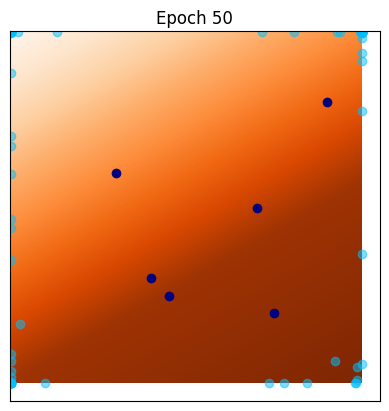

[51/100] 	Loss_D: -0.0206	Loss_G: 0.1598
[52/100] 	Loss_D: -0.0171	Loss_G: 0.1525
[53/100] 	Loss_D: -0.0143	Loss_G: 0.1550
[54/100] 	Loss_D: -0.0087	Loss_G: 0.1399
[55/100] 	Loss_D: -0.0087	Loss_G: 0.1368
[56/100] 	Loss_D: -0.0098	Loss_G: 0.1472
[57/100] 	Loss_D: -0.0050	Loss_G: 0.1381
[58/100] 	Loss_D: -0.0016	Loss_G: 0.1326
[59/100] 	Loss_D: -0.0023	Loss_G: 0.1264
[60/100] 	Loss_D: -0.0018	Loss_G: 0.1255


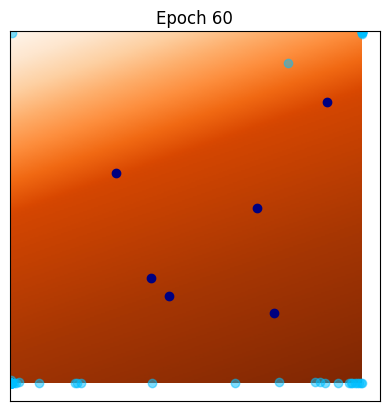

[61/100] 	Loss_D: 0.0001	Loss_G: 0.1000
[62/100] 	Loss_D: -0.0134	Loss_G: 0.1462
[63/100] 	Loss_D: -0.0095	Loss_G: 0.1458
[64/100] 	Loss_D: -0.0091	Loss_G: 0.1405
[65/100] 	Loss_D: -0.0068	Loss_G: 0.1454
[66/100] 	Loss_D: -0.0044	Loss_G: 0.1386
[67/100] 	Loss_D: -0.0020	Loss_G: 0.1363
[68/100] 	Loss_D: -0.0030	Loss_G: 0.1381
[69/100] 	Loss_D: -0.0030	Loss_G: 0.1375
[70/100] 	Loss_D: 0.0009	Loss_G: 0.1357


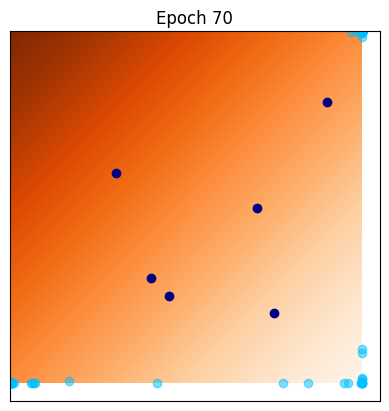

[71/100] 	Loss_D: -0.0018	Loss_G: 0.1193
[72/100] 	Loss_D: -0.0009	Loss_G: 0.1094
[73/100] 	Loss_D: -0.0014	Loss_G: 0.1115
[74/100] 	Loss_D: -0.0047	Loss_G: 0.1225
[75/100] 	Loss_D: 0.0008	Loss_G: 0.1121
[76/100] 	Loss_D: 0.0002	Loss_G: 0.1289
[77/100] 	Loss_D: -0.0036	Loss_G: 0.1296
[78/100] 	Loss_D: -0.0003	Loss_G: 0.1144
[79/100] 	Loss_D: -0.0005	Loss_G: 0.1366
[80/100] 	Loss_D: -0.0003	Loss_G: 0.1083


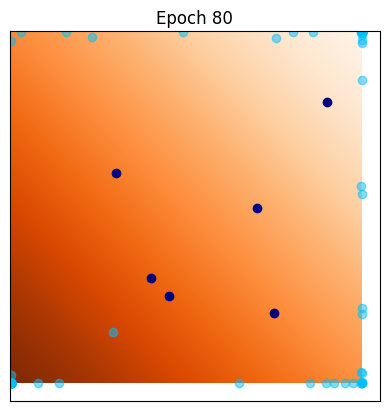

[81/100] 	Loss_D: 0.0000	Loss_G: 0.0960
[82/100] 	Loss_D: -0.0014	Loss_G: 0.1442
[83/100] 	Loss_D: -0.0031	Loss_G: 0.1386
[84/100] 	Loss_D: -0.0000	Loss_G: 0.0976
[85/100] 	Loss_D: -0.0277	Loss_G: 0.1041
[86/100] 	Loss_D: -0.0202	Loss_G: 0.1008
[87/100] 	Loss_D: -0.0153	Loss_G: 0.0922
[88/100] 	Loss_D: -0.0296	Loss_G: 0.1178
[89/100] 	Loss_D: -0.0378	Loss_G: 0.1160
[90/100] 	Loss_D: -0.0255	Loss_G: 0.1024


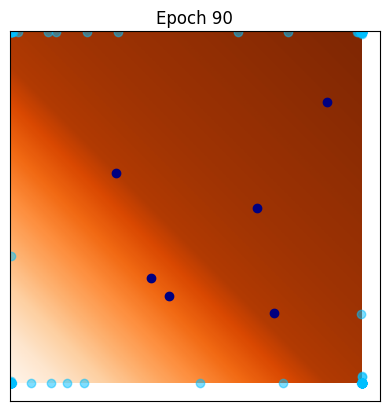

[91/100] 	Loss_D: -0.0193	Loss_G: 0.0851
[92/100] 	Loss_D: -0.0099	Loss_G: 0.0706
[93/100] 	Loss_D: 0.0000	Loss_G: 0.0627
[94/100] 	Loss_D: -0.0344	Loss_G: 0.1115
[95/100] 	Loss_D: -0.0218	Loss_G: 0.0962
[96/100] 	Loss_D: -0.0230	Loss_G: 0.0852
[97/100] 	Loss_D: -0.0121	Loss_G: 0.0817
[98/100] 	Loss_D: -0.0377	Loss_G: 0.1245
[99/100] 	Loss_D: -0.0502	Loss_G: 0.1128


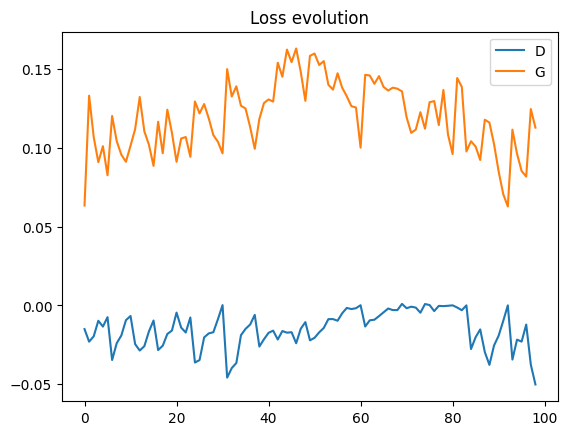

RuntimeError: Error(s) in loading state_dict for Generator:
	size mismatch for hidden.0.0.weight: copying a param with shape torch.Size([100, 10]) from checkpoint, the shape in current model is torch.Size([10, 10]).
	size mismatch for hidden.0.0.bias: copying a param with shape torch.Size([100]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for hidden.1.0.weight: copying a param with shape torch.Size([100, 100]) from checkpoint, the shape in current model is torch.Size([10, 10]).
	size mismatch for hidden.1.0.bias: copying a param with shape torch.Size([100]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for hidden.2.0.weight: copying a param with shape torch.Size([100, 100]) from checkpoint, the shape in current model is torch.Size([10, 10]).
	size mismatch for hidden.2.0.bias: copying a param with shape torch.Size([100]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for out.0.weight: copying a param with shape torch.Size([2, 100]) from checkpoint, the shape in current model is torch.Size([2, 10]).

In [19]:
lr = 0.002   # learning rate for generator

## parameters for training
n_epochs = 100
niterD=1000
niterG=10



lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD = 1000

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generator and discriminator
### ... ###
D = DWGAN(n_in=d, n_hid=10).to(device)

optimG = optim.Adam(G.parameters(), lr=lr)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []
Dlosses = []

clip_value = .1
iter_display = 10

# Main loop
for epoch in range(1,n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################
    for iter in range(0,niterD):
        ### ... ###
        optimD.zero_grad()
        Dy = D(y)
        z = torch.randn(b, n_in, device = device)
        x = G(z)

        Dx = D(x.detach())
        Dloss = - torch.mean(Dy) + torch.mean(Dx)
        Dloss.backward()
        optimD.step()

        for p in D.parameters():
            p.data.clamp_(-clip_value, clip_value)
    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        ### ... ###
        optimG.zero_grad()
        z = torch.randn(b, n_in, device = device)
        x = G(z)
        Gloss = - torch.mean(D(x))
        Gloss.backward()
        optimG.step()


    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item()))
    Glosses.append(Gloss.item())
    Dlosses.append(Dloss.item())

    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


### Plot the evolution of the discriminator and generator losses ###

plt.figure(dpi=100)
plt.plot(Dlosses,label='D')
plt.plot(Glosses,label='G')
plt.title('Loss evolution')
plt.legend()
plt.show()

# Save final generator for later use
wganwc = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wganwc.load_state_dict(G.state_dict())

## Estimate the Lipschitz constant of the discriminator

QUESTION: Implement a function computing an estimation of the Lipschitz constant of $D$ on points that are interpolated between $x$ and $y$.

Use this function to examine the Lipschitz constant of the final discriminator obtained with WGAN-WC.

In [20]:
def lipconstant(D,x,y):
    # Calculate interpolation
    b = x.shape[0]
    n = y.shape[0]
    alpha = torch.rand((b,n,1),device=device)
    interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
    interp.requires_grad_()

    # Calculate discriminator on interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradients, create_graph=True, retain_graph=True, only_inputs=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients **2, dim = 1))

    # Return gradient penalty
    return torch.mean(gradients_norm)

#### (lip constant of the current D) ###

lipconstant(D,x,y)

tensor(0.0839, device='cuda:0', grad_fn=<MeanBackward0>)

## Gradient Penalty

QUESTION: Implement a function computing the gradient penalty of $D$ on points that are interpolated between $x$ and $y$.

In [21]:
def gradient_penalty(D,x,y):
    # Calculate interpolation
    b = x.shape[0]
    n = y.shape[0]
    alpha = torch.rand((b,n,1),device=device)
    interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
    interp.requires_grad_()

    #### ... ###
    Di = D(interp).view(-1)

    # Return gradient penalty
    #### ... ###
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout, create_graph=True, retain_graph=True, only_inputs=True)[0]

    ## Derivation of the gradient close to 0 can cause problems because of the square root. so manually calculate norm and epsilon

    gradients_norm = torch.sqrt(torch.sum(gradients **2, dim = 1)+ 1e-12)

    return torch.mean((gradients_norm - 1) ** 2).mean()

print(gradient_penalty(D,x,y))


tensor(0.8409, device='cuda:0', grad_fn=<MeanBackward0>)


## Train the WGAN-GP discriminator for a fixed generator

QUESTION: Complete the following code at the blocks ###...###.

Adjust the weight of the gradient penalty (parameter `gpw`) to get a Lipschitz constant $\leq 1$.

How would you judge the resulting discriminator?

In [ ]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# Reinitialize generators and discriminators
#### ... ###

optimG = optim.Adam(G.parameters(), lr=lr)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
gpw = 1
niterD=1000

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):

    #### ... ###
    # (adapt the loop written for WGAN-WC)

In [ ]:
print('Final estimated Lipschitz constant = ',lipconstant(D,x,y).item())

plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()

## Train both the Generator and Discriminator

QUESTION: Learn both generator and discriminator with the gradient penalty term

In [ ]:
lr = 0.002   # learning rate for generator

## parameters for training
n_epochs = 100
niterD=1000
niterG=10

lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
gpw = 0.1
niterD=100

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = DWGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []
Dlosses = []

iter_display = 5

#### ... ###
# (adapt the loop written for WGAN-WC)


# Save final generator for later use
wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())

<br/><br/><br/><br/>

# Exercise 2: Learn a GAN

## Define Discriminator Architecture

QUESTION: What do you have to change to get a discriminator adapted for GAN training?

In [ ]:
class DGAN(nn.Module):
  def __init__(self, n_in, n_hid=10):
    super(DGAN, self).__init__()

    self.n_hid = n_hid
    self.n_in = n_in

    self.fc1 = nn.Linear(n_in, n_hid)
    self.fc2 = nn.Linear(n_hid, n_hid)
    self.fc3 = nn.Linear(n_hid, 1)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    y = nn.Sigmoid()(self.fc3(y))
    return y

## Train the discriminator for a fixed generator

QUESTION: Complete the following code at the blocks ###...###

In [ ]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000

D = DGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###
    optimD.zero_grad()
    ### ... ###
    Dloss = ### ... ###
    Dloss.backward()
    optimD.step()

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


In [ ]:
### Plot the evolution of the discriminator loss ###

plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()

## Train both the Generator and Discriminator

In [ ]:
lr = 0.002   # learning rate for generator

## parameters for training
n_epochs = 100
niterD=1000
niterG=10

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
### ... ###

Glosses = []
Dlosses = []

iter_display = 10

# Main loop
for epoch in range(n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################
    for iter in range(0,niterD):
        ### ... ###

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        ### ... ###

    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item()))
    Glosses.append(Gloss.item())
    Dlosses.append(-Dloss.item())


    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, 1, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

# Save final generator for later use
gan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
gan.load_state_dict(G.state_dict())

In [ ]:
### Plot the evolution of the discriminator and generator losses ###

plt.figure(dpi=100)
plt.plot(Dlosses,label='D')
plt.plot(Glosses,label='G')
plt.title('Loss evolution')
plt.legend()
plt.show()

## Train the generator only

QUESTION: For a fixed discriminator, optimize only the generator only. Can you explain what is happening then?

In [ ]:
### ... ###

<br/><br/><br/><br/>